In [1]:
!pip install transformers diffusers torch accelerate sentencepiece

In [2]:
import torch
from transformers import pipeline, set_seed, AutoTokenizer, AutoModelForCausalLM
from diffusers import StableDiffusionPipeline
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [3]:
class TextGenerator:
    def __init__(self, model_name="EleutherAI/gpt-neo-1.3B"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            low_cpu_mem_usage=True,
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def generate_text(self, prompt, max_length=150, temperature=0.8, top_k=50, top_p=0.95):
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        outputs = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=self.tokenizer.eos_token_id,
        )
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

In [7]:
class ImageGenerator:
    def __init__(self, model_name="stabilityai/stable-diffusion-2-1"):
        self.pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float32)
        self.pipe = self.pipe.to("cpu")

    def generate_image(self, prompt):
        """Generates an image based on the given prompt."""
        image = self.pipe(prompt).images[0]
        return image

In [8]:
class StoryGenerator:
    def __init__(self):
        self.text_gen = TextGenerator()
        self.image_gen = ImageGenerator()

    def generate_story(self, prompt):
        """
        Generates a balanced story and an image based on the given prompt.
        """
        story = self.text_gen.generate_text(prompt)
        image = self.image_gen.generate_image(prompt)
        return story, image

In [9]:
def display_story(story, image):
    """Displays the story and image."""
    print("Generated Story:")
    print(story)
    print("\nGenerated Image:")
    display(image)


# Initialize the story generator
story_gen = StoryGenerator()

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated Story:
Once upon a time in a mystical forest, a young girl discovered a magical pendant. The pendant was a magical book, containing a magical spell that would turn the young girl's body into a statue. The spell could be reversed by the spell book, and once the spell was in the statue's body, it would grow stronger and stronger and eventually turn the statue into a dragon.

In the beginning, the spell books were kept in the tree at the very bottom of the forest. The spell books were magic books that contained spell spells and other magical spells. The young girl, in the beginning, was unaware of the magic of the spell books. The young girl had been born in the magical forest. In the beginning, the spell

Generated Image:


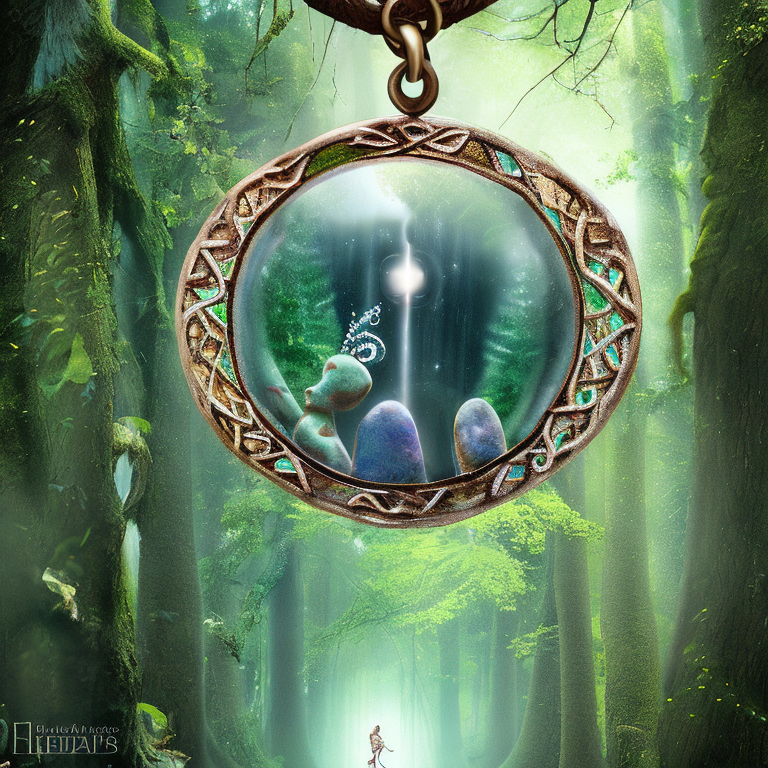

In [10]:
# Get user input
# user_prompt = input("Enter a prompt for your story: ")
user_prompt = "Once upon a time in a mystical forest, a young girl discovered a magical pendant."

# Generate story and image
generated_story, generated_image = story_gen.generate_story(user_prompt)

# Display the results
display_story(generated_story, generated_image)

In [3]:
import os
from transformers import AutoTokenizer, AutoModelForCausalLM

class TextGenerator:
    def __init__(self, model_name="EleutherAI/gpt-neo-1.3B", model_dir="/content/gpt-neo"):
        self.model_dir = model_dir
        if os.path.exists(model_dir):
            print("Loading model from saved files...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
            self.model = AutoModelForCausalLM.from_pretrained(model_dir)
        else:
            print("Downloading and saving model...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
            self.model = AutoModelForCausalLM.from_pretrained(
                model_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                low_cpu_mem_usage=True,
            )
            # Save the model and tokenizer
            os.makedirs(model_dir, exist_ok=True)
            self.tokenizer.save_pretrained(model_dir)
            self.model.save_pretrained(model_dir)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    def preprocess_prompt(self, prompt):
        """Add ethical guidelines or context to the prompt."""
        guidelines = (
            "Write a meaningful, unbiased, and ethical story that promotes creativity "
            "and does not contain harmful or offensive content. "
        )
        return f"{guidelines}{prompt}"

    def generate_text(self, prompt, max_length=300, temperature=0.8, top_k=50, top_p=0.95):
        """Generate a story based on the given prompt."""
        processed_prompt = self.preprocess_prompt(prompt)
        inputs = self.tokenizer(processed_prompt, return_tensors="pt").to(self.device)
        outputs = self.model.generate(
            inputs["input_ids"],
            max_length=max_length,
            temperature=temperature,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=self.tokenizer.eos_token_id,
        )
        story = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return story

    def summarize_story(self, story, max_length=100, min_length=30):
        """Generate a summary for the story."""
        summary = self.summarizer(story, max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]['summary_text']

    def generate_summary(self, prompt):
        """Generate a story and return only the summary."""
        story = self.generate_text(prompt)
        summary = self.summarize_story(story)
        return summary


In [4]:
from diffusers import StableDiffusionPipeline

class ImageGenerator:
    def __init__(self, model_name="stabilityai/stable-diffusion-2-1", model_dir="/content/stable-diffusion"):
        self.model_dir = model_dir
        if not os.path.exists(model_dir):  # Check if the model is already saved
            print(f"Downloading and saving {model_name} to {model_dir}...")
            self.pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float32)
            self.pipe.save_pretrained(model_dir)
            print("Model saved!")
        else:
            print(f"Loading {model_name} from {model_dir}...")
            self.pipe = StableDiffusionPipeline.from_pretrained(model_dir, torch_dtype=torch.float32)
        self.pipe = self.pipe.to("cpu")

    def generate_image(self, prompt):
        """Generates an image based on the given prompt."""
        image = self.pipe(prompt).images[0]
        return image

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Model saved!


  0%|          | 0/50 [00:00<?, ?it/s]

Generated Story:
Write a meaningful, unbiased, and ethical story that promotes creativity and does not contain harmful or offensive content. Once upon a time in a mystical forest, a young girl discovered a magical pendant. Using her unique powers of observation, she witnessed the world around her through it.

The story starts with the young girl named Eiko who was a student at the National Defense Academy in Okinawa. On the day she had to go on duty, she woke up to a strange noise that frightened her. She soon realized that it was a strange sound from the trees and her heart started beating faster and she began to experience strange feelings. Soon, she noticed that she was being watched by a strange man named Ichika who was on the lookout for his mother. When she discovered that he was watching her, she started to fear him. However, she later learned that he was actually her uncle, who was watching her as well.

The story then continues with Eiko as she tries to find her mother and unc

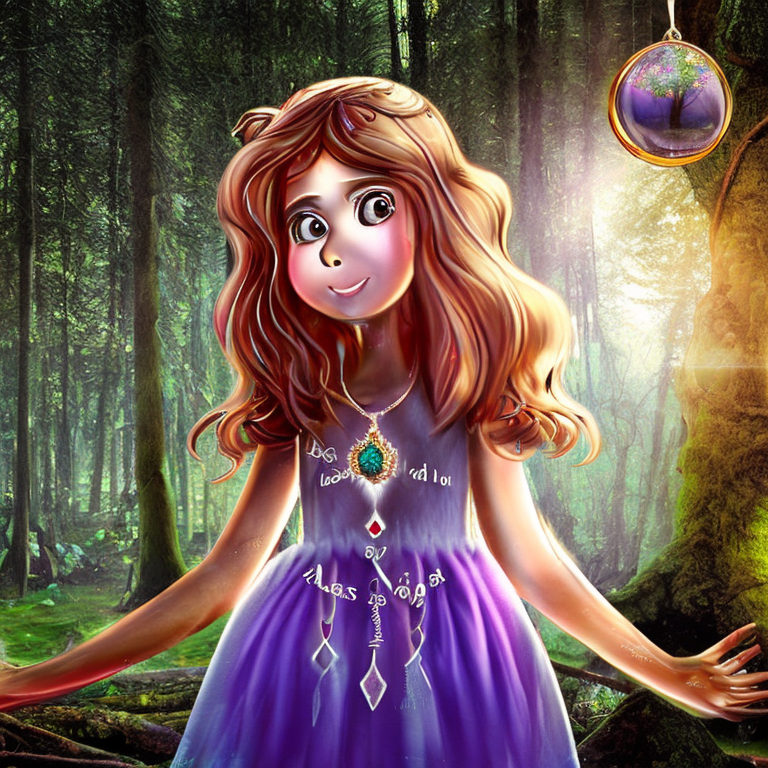

In [5]:
# Initialize with saved models
text_gen = TextGenerator(model_dir="/content/gpt-neo")
image_gen = ImageGenerator(model_dir="/content/stable-diffusion")

# Generate text and image for a prompt
prompt = "Once upon a time in a mystical forest, a young girl discovered a magical pendant."
story = text_gen.generate_text(prompt, max_length=300, temperature=0.8)
image = image_gen.generate_image(prompt)

# Display results
from IPython.display import display
print("Generated Story:")
print(story)
print("\nGenerated Image:")
display(image)

In [9]:
from sentence_transformers import SentenceTransformer, util

# Initialize the model
story_scorer = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
pip install sentence-transformers

In [11]:
from sentence_transformers import SentenceTransformer, util

# Initialize story
story_scorer = SentenceTransformer('all-MiniLM-L6-v2')

def evaluate_story(story_text, prompt):
    """Evaluate narrative structure of the story against the given prompt."""
    # Narrative scoring
    prompt_embedding = story_scorer.encode(prompt, convert_to_tensor=True)
    story_embedding = story_scorer.encode(story_text, convert_to_tensor=True)
    narrative_score = util.cos_sim(prompt_embedding, story_embedding).item()
    return narrative_score

# Example story and prompt
story_output = "Once upon a time, a curious child discovered a magical tree in the forest."
input_prompt = "A magical discovery in the forest by a young adventurer."

# Evaluate the story
narrative_score = evaluate_story(story_output, input_prompt)
print(f"Narrative Score: {narrative_score}")

Narrative Score: 0.7508317232131958
